# SCI Dataset - Pre-processing

In [6]:
import warnings
import string

warnings.simplefilter(action="ignore", category=FutureWarning)

import numpy as np
import pandas as pd
import torch
import transformers as tr

pd.set_option("display.max_columns", None)

import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.ticker as ticker
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sentence_transformers import SentenceTransformer
from sklearn.feature_extraction.text import CountVectorizer

sns.set_theme(style="darkgrid", palette="colorblind")
sns.set(rc={"figure.figsize": (11.5, 8.5), "figure.dpi": 100})

from utils.data_profiling import band_proportions_periodic, sns_multi_time_series, topn_icd_in_year, sci_subset, median_los_per_band, missing_data, single_boxplot
from dataset import SCIData, SCICols

%load_ext autoreload
%autoreload 1
%aimport utils.data_profiling, dataset

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stybl\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [7]:
class Notebook:
    RUN_NLP = True


In [8]:
sci = SCIData.load("data/sci.h5")



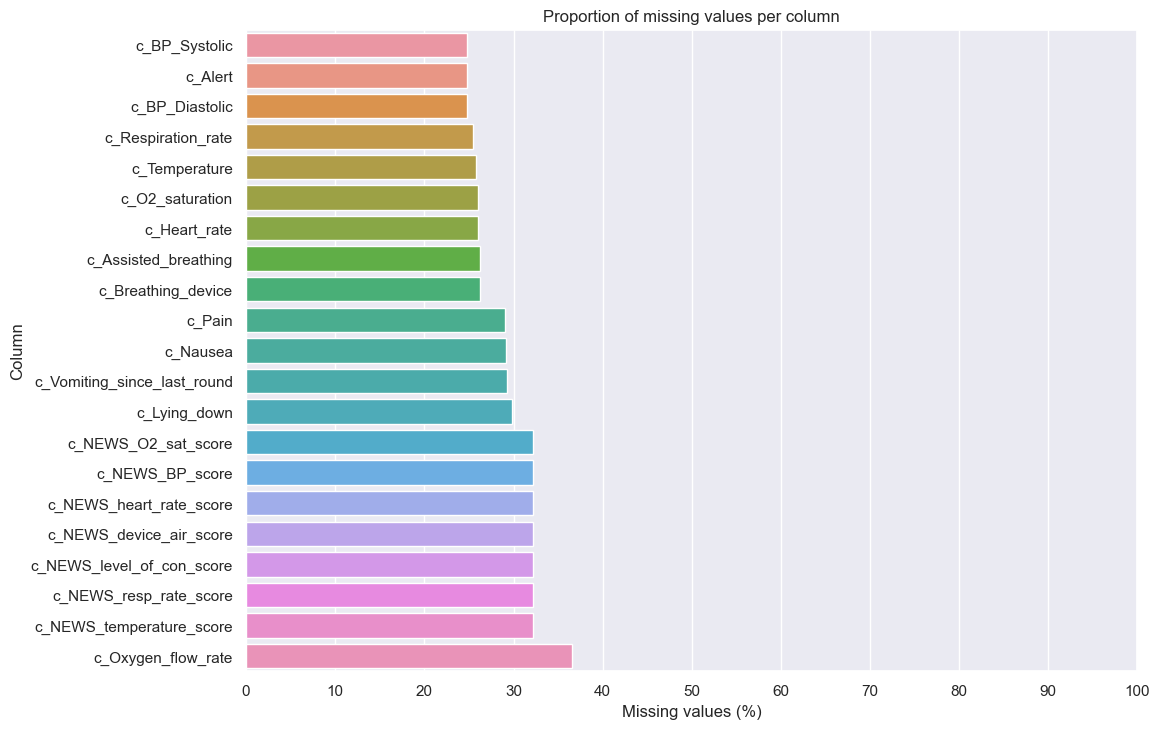

In [9]:
# fig, ax = plt.subplots(figsize=(10,15))
missing_data(sci, SCICols.news_data)


In [150]:
scii = sci.impute_NEWS().impute_blood().omit_vbg()

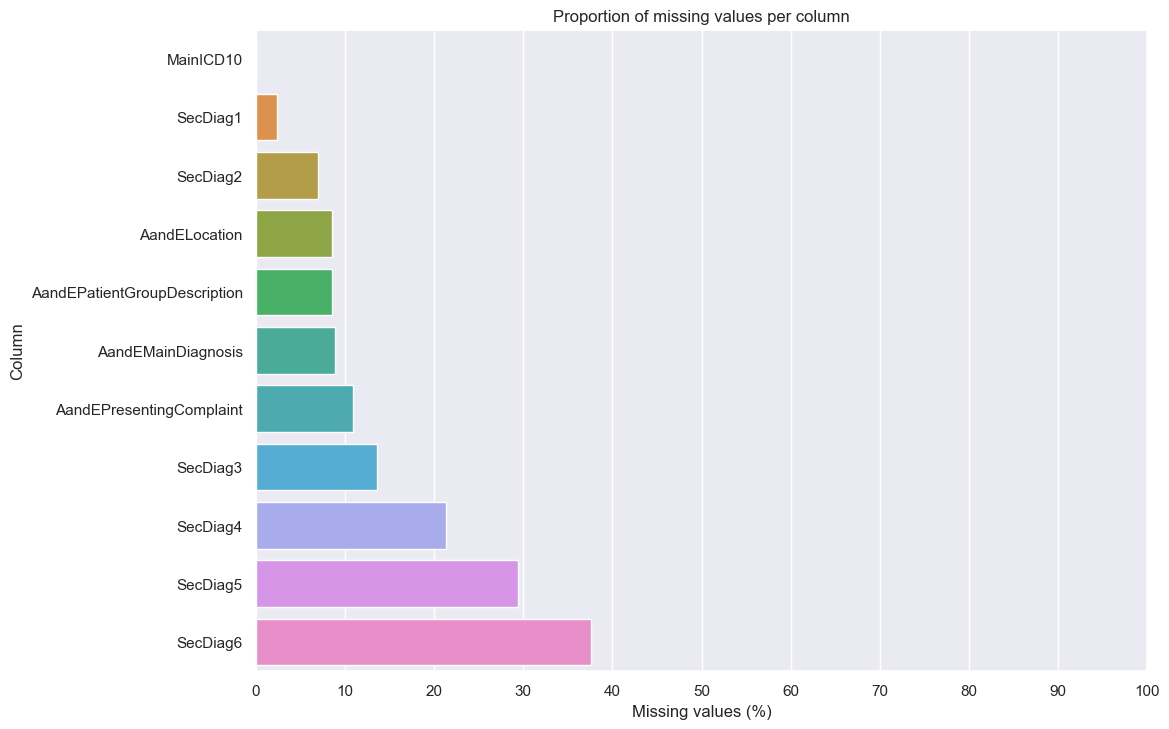

In [41]:
missing_data(scii)

## NEWS Parameters

### O2 Saturation
We consider outliers to be values under `3` standard deviations of the mean (<40.37), or any value >100 (as this is impossible). We correct outliers based on the recorded NEWS O2 saturation score. We set their value to the midpoint of the reference range for scores 0-2. For score = 3, we leave the value as-is.

The NEWS specification gives two reference scales [RCP17, pp.44]:
 - SpO2_1: By default.
 - SpO2_2: For patients with a prescribed oxygen saturation requirement of 88–92% (eg., in patients with hypercapnic respiratory failure).

To trigger SpO2_2 we consider:
 - Anyone with NIV: NIV as assisted breathing device OR 'E85.2' procedure code present
 - COPD (`J44.*` appearing in the patient's Diag codes) AND (Venturi 24 or 28 as assited breathing device OR saturation under 88%)

If the patient is receiving oxygen, there is ambiguity as to whether a high O2 score means high or low saturation. In that case, we delete those values. SpO2_2 patients with score=0 will be assigned the midpoint of the range as normal.

A sizeable proportion of entries have an O2 saturation value but no score, or vice versa. We calculate the score for those given the scales in [RCP17]. 

We can impute values with the median, 97%.

In [88]:
(sci.c_NEWS_O2_sat_score.isna() & sci.c_O2_saturation.notna()).sum()


10645

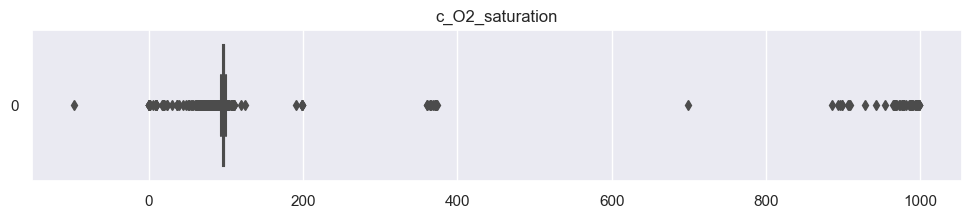

In [89]:
single_boxplot(sci, "c_O2_saturation")



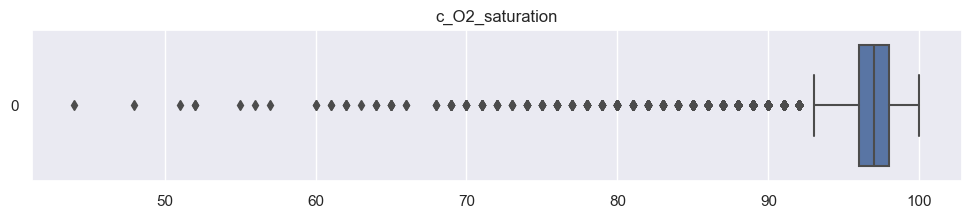

In [90]:
scii = sci.clean_O2_saturation()
single_boxplot(scii, "c_O2_saturation")



### Blood Pressure

To be included, values must be:
 - Diastolic: Within $20 \leq d \leq 200$
 - Systolic: Within $40 \leq s \leq 300$ and it must hold $s \geq d+5$

As before, we fill missing systolic NEWS scores using the raw value where available. We infer missing systolic BP values from the score, if one is available and is not = 3, as a score of 3 is ambiguous.

We can impute both with their medians, Systolic: 124 and Diastolic: 70

In [16]:
sci.c_BP_Diastolic.median()

70.0

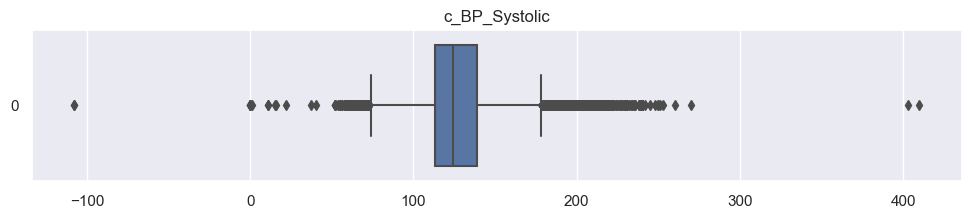

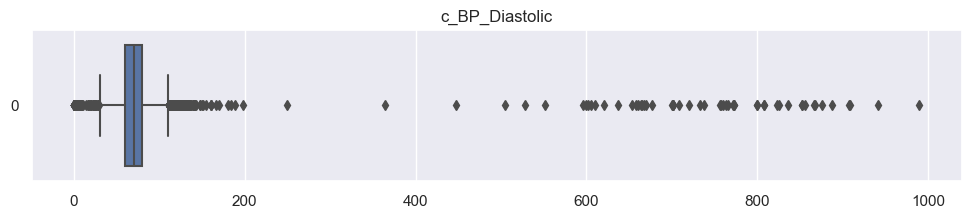

In [91]:
single_boxplot(sci, "c_BP_Systolic")
single_boxplot(sci, "c_BP_Diastolic")



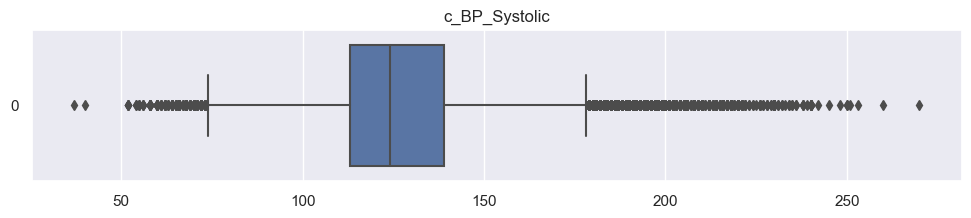

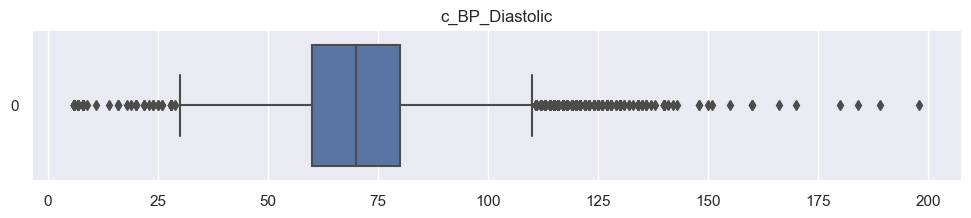

In [92]:
scii = sci.clean_blood_pressure()
single_boxplot(scii, "c_BP_Systolic")
single_boxplot(scii, "c_BP_Diastolic")



### Respiration Rate

We follow the previous methodology for supplementing scores and values. There are no clear guidelines on cutoff points for the respiration rate, as [Fernandes20] only excludes values $>80$. As an (outwardly) reasonable starting point we also exclude values $<5$. 

Triple-digit values such as 250 are assumed to mean 25. Negative values are inverted. 

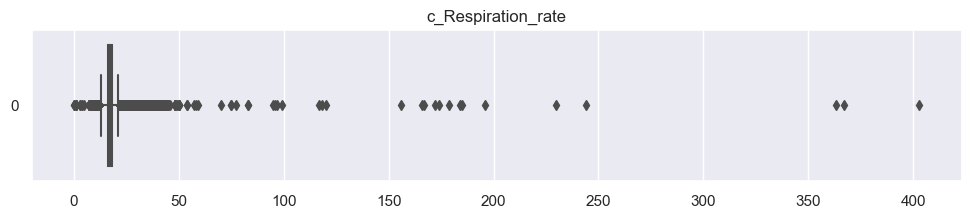

In [93]:
single_boxplot(sci, "c_Respiration_rate")



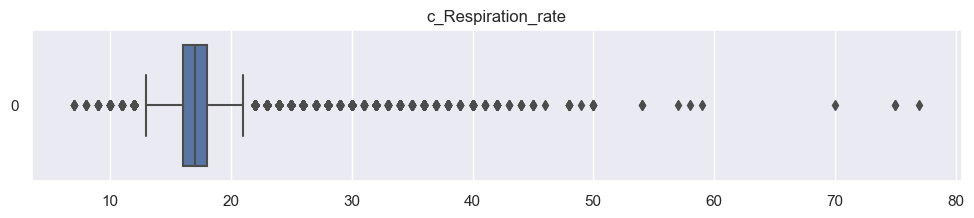

In [94]:
scii = sci.clean_respiration_rate()
single_boxplot(scii, "c_Respiration_rate")



### Device Air

Just filling missing values between the score and value columns.

In [95]:
scii = sci.clean_device_air()


### Temperature

[Fernandes20] gives $20$ as the low-end cutoff for temperature. I increase this to $25$ as it seems more reasonable.

Within 3 std. is $35.22-38.30$

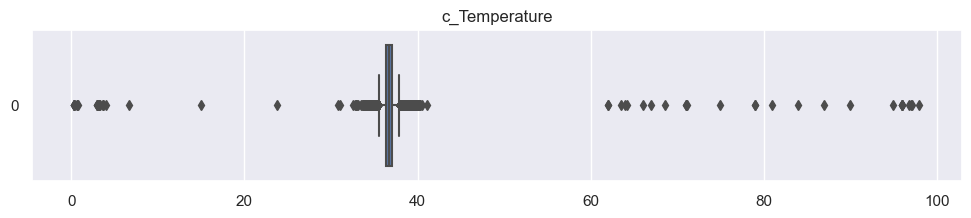

In [96]:
single_boxplot(sci, "c_Temperature")



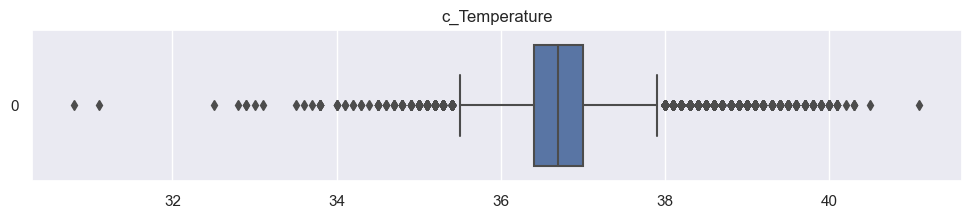

In [97]:
scii = sci.clean_temperature()
single_boxplot(scii, "c_Temperature")



### Heart Rate

[Fernandes20] eliminates values over 300. Within 3 std is $34.47-127.3$. We set a lower limit of 25. Median is 80.

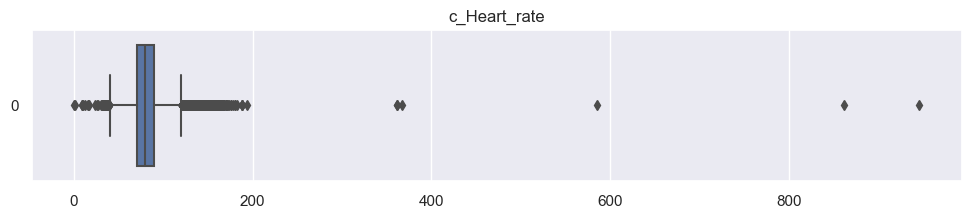

In [98]:
single_boxplot(sci, "c_Heart_rate")



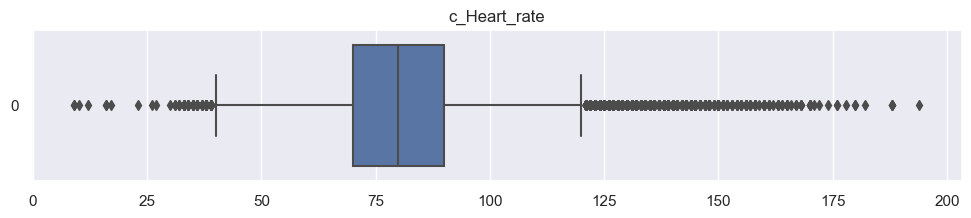

In [99]:
scii = sci.clean_heart_rate()
single_boxplot(scii, "c_Heart_rate")



### Consciousness

This can be un-binarised to allow all options for CVPU. However, the number of samples is quite small.

In [100]:
scii = sci.clean_consciousness()


### Oxygen Flow Rate

This may be measured in LPM or FiO2. Can reasonably infer depending on the type of breathing device used:

 - Values 1-15 will likely be LPM
 - Decimals will likely be FiO2 except:
     - 0.5 is commonly LPM.
     - Determine LPM if device is Nasal Cannula or Mask
 - Remaining will be FiO2 if serious devices are used (NIV, venturi, etc)

We standardise to FiO2 based on the formula from [here](https://www.biomadam.com/how-to-calculate-fio2-from-liters):

$FiO2 = 20\% + (LPM * 4)$

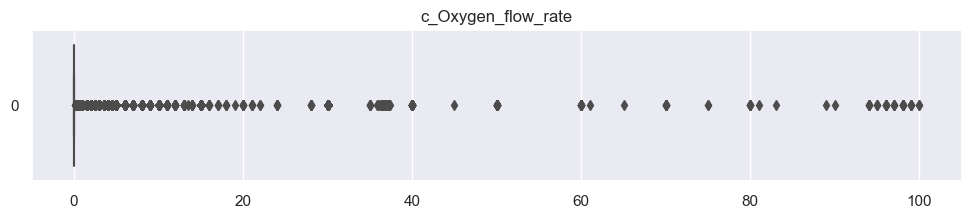

In [37]:
single_boxplot(sci, 'c_Oxygen_flow_rate')

In [101]:
sci.c_Oxygen_flow_rate.mean()


0.5541313678613957

In [32]:
((sci.c_Oxygen_flow_rate > 1) & (sci.c_Oxygen_flow_rate <= 15)).sum()


9797

In [25]:
((sci.c_Oxygen_flow_rate == 0.5) & (sci.c_Breathing_device.isin(['N - Nasal cannula', 'SM - Simple mask']))).sum()

297

In [31]:
((sci.c_Oxygen_flow_rate > 15) & ~(sci.c_Breathing_device.isin(['A - Air', 'N - Nasal cannula', 'SM - Simple mask']))).sum()

360

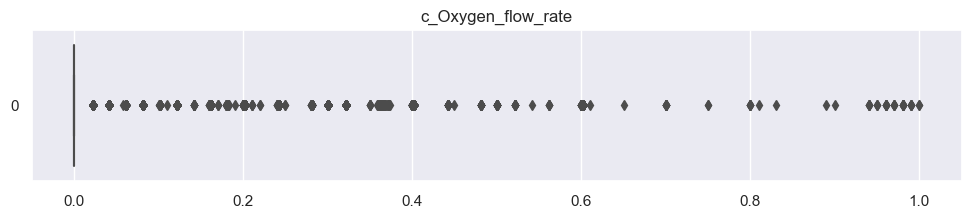

In [50]:
single_boxplot(sci.clean_O2_flow_rate(), "c_Oxygen_flow_rate")



### Score

Since we have cleaned all the NEWS components, we can derive the final score where necessary by summing them up.

In [112]:
def compare_news(df):
    news_new = df[SCICols.news_data_scored].sum(axis=1)
    has_params = df[SCICols.news_data_scored].notna().all(axis=1)
    has_news = df.c_NEWS_score.notna()
    params_only = has_params & (~has_news)
    news_disagrees = has_params & has_news & (news_new != df.c_NEWS_score)

    print(
        f"Records without NEWS: {(~has_news).sum()} = {((~has_news).sum()/df.shape[0]*100).round(3)}%"
    )
    print(
        f"Records with params but no NEWS: {params_only.sum()} = {(params_only.sum()/df.shape[0]*100).round(3)}%"
    )
    print(
        f"Records where NEWS disagrees with params: {news_disagrees.sum()} = {(news_disagrees.sum()/df.shape[0]*100).round(3)}%"
    )



In [105]:
scii = sci.clean_all()

In [114]:
compare_news(scii)

Records without NEWS: 46490 = 27.214%
Records with params but no NEWS: 0 = 0.0%
Records where NEWS disagrees with params: 0 = 0.0%


## Blood

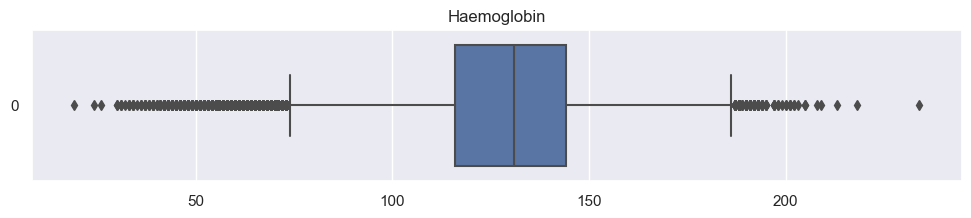

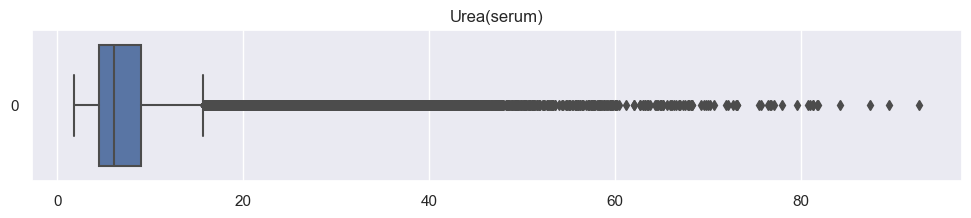

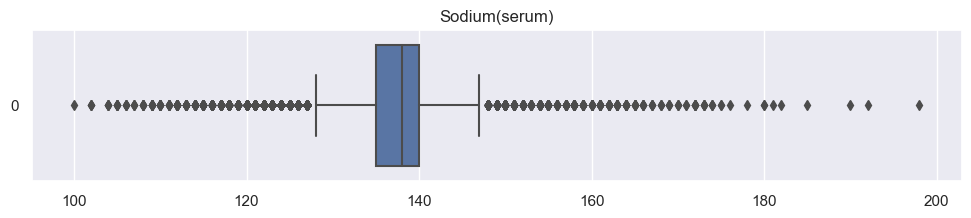

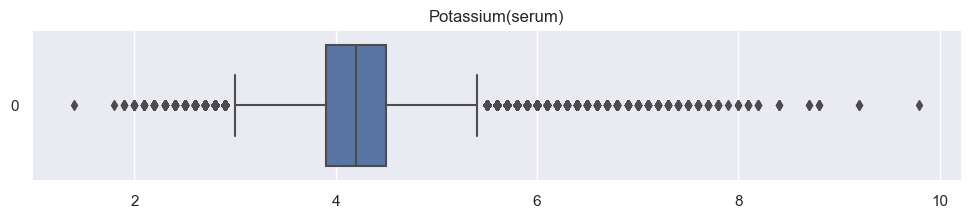

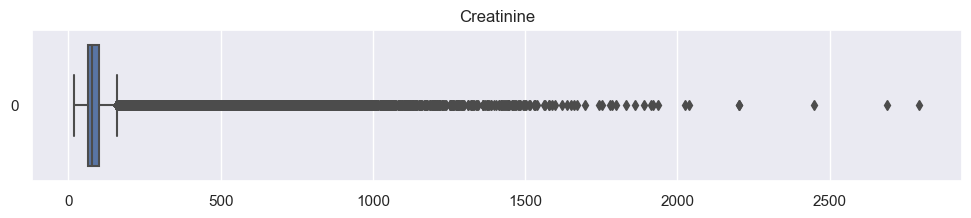

In [23]:
for col in SCICols.blood:
    single_boxplot(sci, col)


## Venous Blood Gas

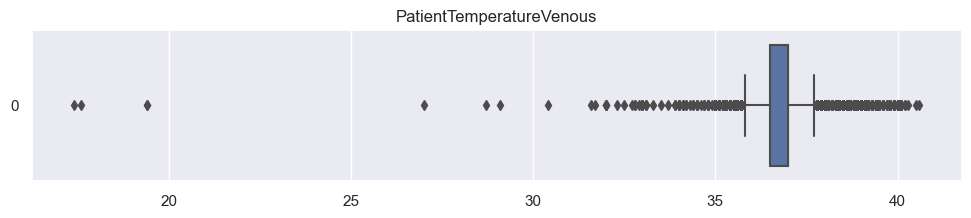

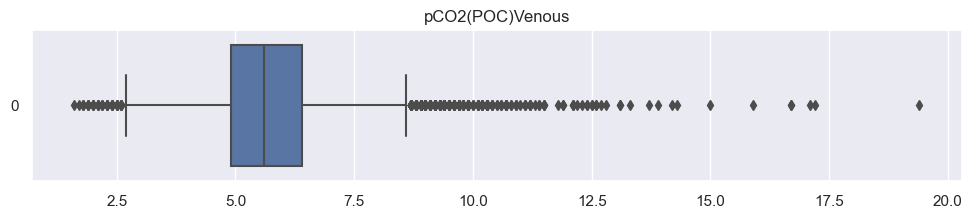

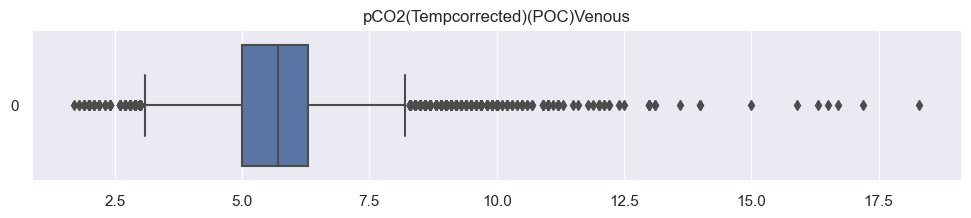

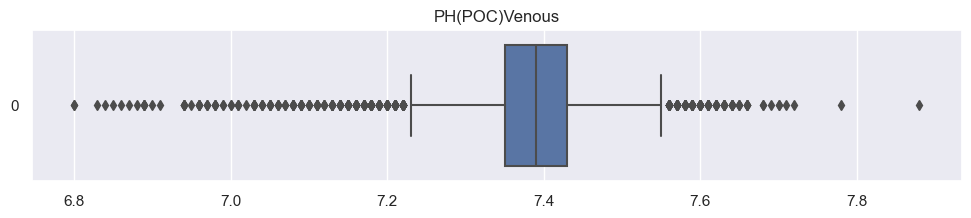

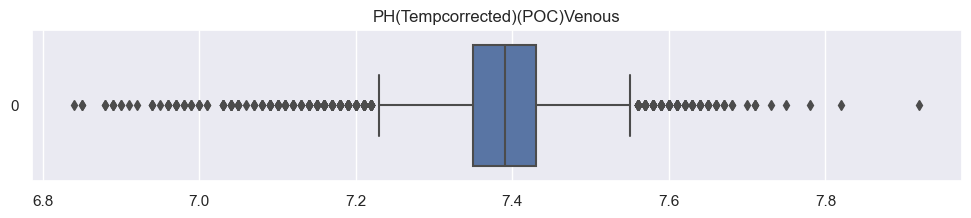

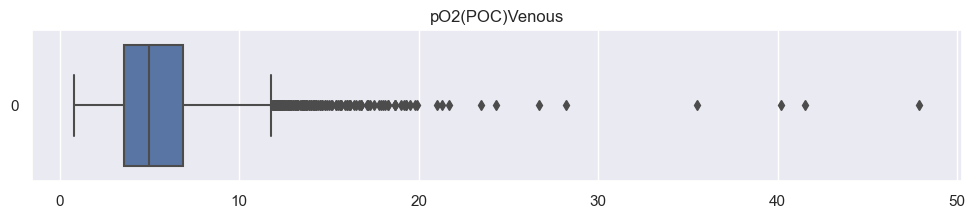

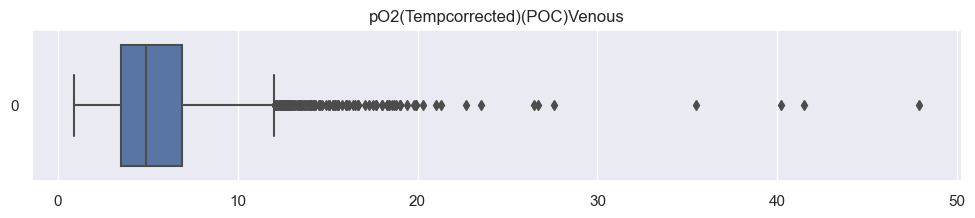

In [24]:
for _ in SCICols.vbg:
    single_boxplot(sci, _)


## A&E Unstructured Text

### Presenting Complaint

The top 50 most frequent values for this field (after some basic cleaning) make up 97.06% of entries that have a presenting complaint. Filtering out "vague" complaints such as 'unwell adult' (which happens to be the #1 most frequent value) doesn't alter the proportion by much (96.32%).

In [25]:
scii = sci.clean_ae_text()
col = scii.AandEPresentingComplaint
round(col.value_counts().head(50).sum() / col.notna().sum() * 100, 2)



96.32

### Main Diagnosis
Contrarily, the top 50 most frequent values for this field only make up 61.63% of entries that have a presenting complaint. However, the outcomes are still distributed similarly. Removing vague entries reduces this to 52.62%.

The #2 most frequent value is "referral to service (procedure)". What do we make of this?

In [26]:
col = scii.AandEMainDiagnosis.str.lower().str.strip(" ?+")
round(col.value_counts().head(50).sum() / col.notna().sum() * 100, 2)



52.62

In [27]:
stops, vec = frozenset(stopwords.words("english")), CountVectorizer()
X = vec.fit_transform(sci.clean_ae_text().AandEMainDiagnosis.dropna().values)


In [28]:
print(
    "Top 20 words: "
    + ", ".join(
        [
            word
            for freq, word in sorted(
                zip(X.sum(axis=0).tolist()[0], vec.get_feature_names_out()),
                reverse=True,
            )
            if word not in stops
        ][:20]
    )
)



Top 20 words: disorder, finding, pain, acute, syndrome, disease, chest, injury, pneumonia, overdose, tract, adults, chronic, septicemia, coronary, abdominal, obstructive, urinary, detected, abnormality


We can generate a contextualised word embedding using Bio_Clinical BERT. 

For BERT we do this by omitting the decoders from the model and accessing the hidden layers. [They](http://jalammar.github.io/illustrated-bert/) mention that concatenating the final 4 layers gives the best performance (very close to a fine-tuned BERT for NER) but we will sum instead. This reduces dimensionality but performance is comparable. 

We skip subword pooling as I don't have time to wrap my head around it and it has been found not to be very important in named entity recognition tasks ([source](https://arxiv.org/pdf/2102.10864.pdf)). 



In [29]:
if Notebook.RUN_NLP:
    config = tr.AutoConfig.from_pretrained(
        "emilyalsentzer/Bio_ClinicalBERT",
        output_hidden_states=True,
        output_attentions=False,
    )
    tokenizer, model = (
        tr.AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT"),
        tr.AutoModel.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", config=config),
    )



Some weights of the model checkpoint at emilyalsentzer/Bio_ClinicalBERT were not used when initializing BertModel: ['cls.predictions.decoder.weight', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [30]:
def get_hidden(encoded, model, layers=[-4, -3, -2, -1]):
    """ Equivalent to TransformersEmbedder() with no subword pooling and "sum" layer pooling """
    with torch.no_grad():
        output = model(**encoded, output_hidden_states=True)

    return torch.stack([output.hidden_states[i] for i in layers]).sum(0).squeeze()


In [31]:
if Notebook.RUN_NLP:
    encoded = tokenizer(
        scii.AandEMainDiagnosis.dropna().values[:1000].tolist(),
        padding=True,
        return_tensors="pt",
    )
    embeddings = get_hidden(encoded, model)
    embeddings.shape


To get fixed-size vector embeddings of short phrases/sentences, two common techniques are using either the embedding of the technical symbol `[CLS]` that is prepended to the sentence before processing it with BERT; or an average of the contextual sub-word vectors [Reimers19]. 

These don't necessarily perform well but have been used and investigated extensively.

In [39]:
if Notebook.RUN_NLP:
    cls_embeddings = embeddings[:, 0, :]
    mean_embeddings = torch.mean(embeddings, axis=1)
    print(cls_embeddings.shape)
    print(mean_embeddings.shape)



torch.Size([1000, 768])
torch.Size([1000, 768])


Phrase-BERT is specialised in producing phrase embeddings. Trained on a general-purpose corpus, not clinical. 

In [42]:
if Notebook.RUN_NLP:
    model = SentenceTransformer('whaleloops/phrase-bert')
    embeddings = model.encode(scii.AandEMainDiagnosis.dropna().values[:1000].tolist())
    print(embeddings.shape)

### Patient Group Description

Seems reasonable to group some uncommon terms under more common ones:
 - "falls", "road traffic accident", "sports injury" -> "accident"
 - "knife injuries" -> "assault"

In [112]:
sci.clean_ae_patient_group().AandEPatientGroupDescription.value_counts()


medical             100675
other                40854
surgical              4463
trauma                3706
psychiatric           2751
ortho non trauma      1370
ent                    972
obs/gyn                812
neurosurgical          669
Name: AandEPatientGroupDescription, dtype: int64

## ICD-10

Around ~16k entries end with ' D' or ' A', or '.X'. These can't be matched with the external ICD-10 table so these endings are deleted. 

A tiny subset of (otherwise valid) remaining ICD-10 codes don't exist in the table. We delete these.

In [114]:
icd10 = pd.read_hdf('data/icd10.h5', 'ICD10_Codes')
print(
    f"Unmatched values before: {(~sci.MainICD10.isin(icd10.index) & sci.MainICD10.notna()).sum()}"
)



Unmatched values before: 19376


In [115]:
scii = sci.clean_icd10(icd10)
print(
    f"Unmatched values after: {(~scii.MainICD10.isin(icd10.index) & scii.MainICD10.notna()).sum()}"
)



Unmatched values after: 0


[Hassani15] gives a set of ICD-10 codes considered "vague", such as those only describing generic symptoms (e.g., R00-R56). We can filter those out and justify the columns such that, if the Main ICD-10 was vague, the first non-vague ICD-10 becomes the Main.

In [116]:
ranges = [
    ("R", 00, 56),
    ("R", 58, 64),
    ("R", 66, 94),
    ("V", 1, 98),
    ("Z", 00, 13),
    ("Z", 20, 29),
    ("Z", 32, 36),
    ("Z", 39, 39),
    ("Z", 43, 48),
    ("Z", 52, 99),
]

vague = frozenset(
    f"{letter}{str(num).zfill(2)}"
    for letter, start, stop in ranges
    for num in range(start, stop + 1)
)

print(
    f"Vague ICD-10s: {sci[SCICols.diagnoses].apply(lambda c: c.str[:3]).isin(vague).sum().sum()}"
)
print(sci[SCICols.diagnoses].apply(lambda c: c.str[:3]).isin(vague).sum())


Vague ICD-10s: 227014
MainICD10    37225
SecDiag1     34819
SecDiag2     33864
SecDiag3     31653
SecDiag4     30559
SecDiag5     29703
SecDiag6     29191
dtype: int64


In [117]:
scii = sci.filter_vague_diagnoses()
print(
    f"Vague ICD-10s: {scii[SCICols.diagnoses].apply(lambda c: c.str[:3]).isin(vague).sum().sum()}"
)
print(scii[SCICols.diagnoses].apply(lambda c: c.str[:3]).isin(vague).sum())


Vague ICD-10s: 0
MainICD10    0
SecDiag1     0
SecDiag2     0
SecDiag3     0
SecDiag4     0
SecDiag5     0
SecDiag6     0
dtype: int64


### Augmenting

We can augment SCI with ICD-10 metadata, such as full descriptions or groupings into:
 - 3-Codes
 - Groups
 - Chapters

In [118]:
scii.augment_icd10_descriptions()[["MainICD10", "WHO_Full_Desc"]].head()



,MainICD10,WHO_Full_Desc
0,T43.5,"Poisoning, other and unspecified antipsychotic..."
1,M25.56,"Pain in joint, lower leg"
2,E78.0,Pure hypercholesterolaemia
3,T44.3,"Poisoning, other parasympatholytics [anticholi..."
4,T43.2,"Poisoning, other and unspecified antidepressants"


In [119]:
scii.augment_icd10_grouping()[SCICols.icd10_grouping].head()


,Chapter_No,Chapter_Desc,Group_Code,Group_Desc,ICD10_3_Code_Desc
0,CHAPTER XIX,"Injury, poisoning and certain other consequenc...",213 (T36-T50),"Poisoning by drugs, medicaments and biological...","Poisoning by psychotropic drugs, not elsewhere..."
1,CHAPTER XIII,Diseases of the musculoskeletal system and con...,132 (M00-M25),Arthropathies: Other joint disorders,"Other joint disorders, not elsewhere classified"
2,CHAPTER IV,"Endocrine, nutritional and metabolic diseases ...",053 (E70-E90),Metabolic disorders,Disorders of lipoprotein metabolism and other ...
3,CHAPTER XIX,"Injury, poisoning and certain other consequenc...",213 (T36-T50),"Poisoning by drugs, medicaments and biological...",Poisoning by drugs primarily affecting the aut...
4,CHAPTER XIX,"Injury, poisoning and certain other consequenc...",213 (T36-T50),"Poisoning by drugs, medicaments and biological...","Poisoning by psychotropic drugs, not elsewhere..."


CCS Grouping: matches are near-perfect (99.28% match) excluding:
 - Some trauma-related codes: `Yxx.x`, `Wxx.x`
 - Some codes that are near-matches if you do 4-character matching (e.g. `Mxx.xx`) or 3-characters.

In [122]:
ccs = pd.read_hdf('data/ccs.h5', 'codes')
print(
    f'Unmatched: {(scii.join(ccs, on=scii.MainICD10.str.replace(".", "")).CCSGroup.isna() & scii.MainICD10.notna()).sum()}'
)



Unmatched: 14269


In [123]:
print(
    f"Unmatched after fuzzy: {(scii.augment_ccs(sentinel=[np.nan, np.nan]).CCSGroup.isna() & scii.MainICD10.notna()).sum()}"
)



Unmatched after fuzzy: 866


SHMI Grouping: Groups several CCS codes into 157 diagnostic groups. See [SHMI22] for details.

In [124]:
scii.augment_ccs().augment_shmi()[["SHMIGroup", "SHMIGroupDescription"]].head()



,SHMIGroup,SHMIGroupDescription
0,132.0,Poisoning
1,110.0,Other non-traumatic joint disorders
2,38.0,"Nutritional, endocrine and metabolic disorders"
3,132.0,Poisoning
4,132.0,Poisoning


HSMR Grouping: Groups CCS further into 17 broad aggregate clusters. Applied in the Netherlands but consistent with SHMI. See [HSMR18] for details.

In [125]:
scii.augment_ccs().augment_hsmr()[
    ["AggregateGroup", "AggregateGroupDescription"]
].head()



,AggregateGroup,AggregateGroupDescription
0,16.0,Injury and poisoning
1,13.0,Diseases of the musculoskeletal system and con...
2,3.0,"Endocrine, nutritional and metabolic diseases,..."
3,16.0,Injury and poisoning
4,16.0,Injury and poisoning


## Covid

COVID-19 is coded as:
 - `U07.1`: COVID-19, virus identified
 - `J12.8`: Other viral pneumonia
 - `B97.2`: Coronavirus as the cause of diseases classified to other chapters

Per the [guidelines](https://hscic.kahootz.com/t_c_home/view?objectID=28993424), *all 3* codes should be present for an accurately coded COVID-19 case. 

In [126]:
print(f"Total cases (strict detection): {sci.derive_covid_strict().Covid.sum()}")



Total cases (strict detection): 753


Loosening the definition to only having one of the codes present (only for records starting Jan-2020) more than doubles matches.

In [127]:
print(f"Total cases (non-strict): {sci.derive_covid(force=True).Covid.sum()}")


Total cases (non-strict): 1817


The bulk of these have either `U07.1` or `B97.2` indicating that COVID-19 may have been a comorbidity in these cases.

In [128]:
print(
    f"Total cases (non-strict, excl. viral pneumonia): {sci.derive_covid(covid_codes=['U07.1', 'B97.2'], force=True).Covid.sum()}"
)



Total cases (non-strict, excl. viral pneumonia): 1785


## Critical Care

Critical care is determined by admission to the CCU. Only ~1500 = ~0.9% of records match, so we relax the criteria to include high-dependency wards. We know patients may often be placed in the wrong ward for operational reasons, so we only consider the medical high-dependency ward `"HH1M"`.

In [129]:
print(f"CCU admissions: {(sci[SCICols.wards] == 'CCU').sum().sum()}")
print(f"HH1M admissions: {(sci[SCICols.wards] == 'HH1M').sum().sum()}")


CCU admissions: 1513
HH1M admissions: 4861


In [130]:
scii = sci.derive_readmission().derive_criticalcare()
print(
    f"Critical care total: {scii.CriticalCare.sum()} = {round(scii.CriticalCare.sum()/scii.shape[0]*100, 3)}%"
)
print(
    f"Readmissions leading to critical care: {scii.CriticalReadmission.sum()} = {round(scii.CriticalReadmission.sum()/scii.shape[0]*100, 3)}%"
)
print(
    f"Records that will be readmitted to critical care within time threshold: {scii.CriticalReadmitted.sum()} = {round(scii.CriticalReadmitted.sum()/scii.shape[0]*100, 3)}%"
)



Critical care total: 5081 = 2.974%
Readmissions leading to critical care: 671 = 0.393%
Records that will be readmitted to critical care within time threshold: 425 = 0.249%


## Readmissions

The standard threshold to consider a second spell by the same patient a readmission is 30 days. 
We bin readmission timespands into bands:
 - "24 Hrs", "48 Hrs", "1 Week", "2 Weeks", "1 Month", "2 Months"

We also derive `Readmitted` which looks into the future to indicate whether the patient returned within the specified timespan.

In [131]:
print(
    f"Total readmissions: {scii.Readmission.sum()} = {round(scii.Readmission.sum()/scii.shape[0]*100, 3)}%"
)
print("Readmission band proportions: ")
pd.concat(
    [
        scii.ReadmissionBand.value_counts().rename("% Of Records")
        / scii.shape[0]
        * 100,
        scii.ReadmissionBand.value_counts().rename("% Of Readmissions")
        / scii.Readmission.sum()
        * 100,
    ],
    axis=1,
).round(3).loc[::-1]



Total readmissions: 20767 = 12.156%
Readmission band proportions: 


,% Of Records,% Of Readmissions
24 Hrs,0.506,4.160
48 Hrs,0.639,5.258
1 Week,2.576,21.187
2 Weeks,3.010,24.760
1 Month,5.426,44.633
2 Months,6.297,51.799


## Mortality

In [132]:
print(f"Mortality outcome proportions:")
(sci.derive_mortality().Mortality.value_counts() / sci.shape[0] * 100).round(3).astype(
    str
) + "%"



Mortality outcome proportions:


DidNotDie           93.388%
DiedDuringStay       3.809%
DiedWithin30Days     2.803%
Name: Mortality, dtype: object